In [2]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth, geom_bar,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import matplotlib.pyplot as plt
import patchworklib as pw
import numpy as np
from llm_ran.benchmark.metrics import pass_at, pass_power

from llm_ran.benchmark.questions import TEST_CASES

import plotnine as pn
my_theme = lambda x, y: pn.theme_classic() + pn.theme(
    # axis_text_x=pn.element_text(rotation=15, hjust=1),
    panel_grid_major_y=pn.element_line(size=0.5, color="grey"),
    panel_border=pn.element_rect(size=1, color="black"),
    figure_size=(x, y)
)

productcatalogservice-7476c969c8-5z2sn None


<Figure size 100x100 with 0 Axes>

In [3]:
QUESTIONS_META = {
    (test_case.scenario, question.id): question
    for test_case in TEST_CASES
    for question in test_case.questions
}

levels = ["Simple Fact Finding", "Complex Fact Finding", "Reasoning"]

questions = pd.DataFrame([
    {
        "scenario": test_case.scenario or "base",
        "question": question.id,
        "question_type": levels[question.level],
    }
    for test_case in TEST_CASES
    for question in test_case.questions
]).set_index(["scenario", "question"])
# display(questions)

In [4]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"

mainline_models = [
    "qwen2.5:32b",
    # "qwen2.5-coder:32b",
    "sky-t1:32b",
    "qwq:32b",
]

df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[df['model'].isin(mainline_models)]
df = df.rename(columns={"chain": "agent"})
df = df.join(questions, on=["scenario", "question"])
df['question_type'] = pd.Categorical(df['question_type'], categories=levels, ordered=True)
df['model'] = pd.Categorical(df['model'], categories=mainline_models, ordered=True)

zero_to_na = ["total_tokens"]
for col in zero_to_na:
    df[col] = df[col].replace(0, np.nan)

df.columns

Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation', 'question_type'],
      dtype='object')

In [5]:
group_by = ["model", "agent", "question_type"]
metrics = ["can_answer", "correct", 'execution_time', "total_tokens", "num_messages", "pass"]

agg1 = {
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "can_answer@10": ('can_answer', pass_at(10)),
    "can_answer^10": ('can_answer', pass_power(10)),
    "correct@5": ('correct', pass_at(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct^5": ('correct', pass_power(5)),
    "correct@10": ('correct', pass_at(10)),
    "correct^10": ('correct', pass_power(10)),
    "pass@5": ('pass', pass_at(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass^5": ('pass', pass_power(5)),
    "pass@10": ('pass', pass_at(10)),
    "pass^10": ('pass', pass_power(10)),
    "execution_time": ('execution_time', 'mean'),
    "total_tokens": ('total_tokens', 'mean'),
    "num_messages": ('num_messages', 'mean'),
}
groupby1 = ["scenario", "question"]

raw = df.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index()
display(raw)
raw_pivoted = raw.melt(
    id_vars=group_by,
    value_vars=[*agg1.keys()],
    var_name="metric",
    value_name="value",
)
raw_grouped = raw_pivoted.groupby(
    group_by + ["metric"]
).agg(
    value_min=('value', 'min'),
    value_max=('value', 'max'),
    value=('value', 'mean'),
    value_25=('value', lambda x: x.quantile(0.25)),
    # value_50=('value', lambda x: x.quantile(0.5)),
    value_75=('value', lambda x: x.quantile(0.75)),
).reset_index()
display(raw_grouped)


# resampled = df.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index().groupby(group_by)[list(agg1.keys())].agg('mean').join(
#     df.groupby(group_by)[list(agg.keys())].agg('mean'), on=group_by
# ).reset_index()
# # resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
# # display(resampled)
# pivoted = resampled.melt(
#     id_vars=group_by,
#     value_vars=[*agg.keys(), *agg1.keys()],
#     var_name="metric",
#     value_name="value",
# )

# display(pivoted)

,model,agent,question_type,scenario,question,can_answer@5,can_answer@1,can_answer^5,can_answer@10,can_answer^10,...,correct@10,correct^10,pass@5,pass@1,pass^5,pass@10,pass^10,execution_time,total_tokens,num_messages
0,qwen2.5:32b,codegen,Simple Fact Finding,base,how-many-nodes,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.281637,790.30,4.1
1,qwen2.5:32b,codegen,Simple Fact Finding,base,how-many-nodes-does-a-deployment-use,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,qwen2.5:32b,codegen,Simple Fact Finding,base,how-many-pods-for-deployment,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.00000,1.0,1.000000,1.914194,864.45,4.1
3,qwen2.5:32b,codegen,Simple Fact Finding,base,how-many-pods-for-deployment-pending,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,qwen2.5:32b,codegen,Simple Fact Finding,base,how-many-pods-for-deployment-unhealthy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,qwq:32b,direct,Reasoning,resource-constraint,why-is-deployment-failing,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.00000,1.0,1.000000,40.201936,7581.60,7.1
2426,qwq:32b,direct,Reasoning,resource-constraint,why-is-deployment-not-receiving-traffic,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2427,qwq:32b,direct,Reasoning,resource-constraint,why-is-deployment-not-rolling-out,1.0,1.0,1.0,1.0,1.0,...,1.0,0.028248,1.0,0.7,0.16807,1.0,0.028248,39.976717,6520.80,6.1
2428,qwq:32b,direct,Reasoning,resource-constraint,why-is-pod-pending,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.0,1.0,1.00000,1.0,1.000000,22.210251,4181.70,4.4


,model,agent,question_type,metric,value_min,value_max,value,value_25,value_75
0,qwen2.5:32b,codegen,Simple Fact Finding,can_answer@1,0.0,1.0,0.695833,0.500000,0.925000
1,qwen2.5:32b,codegen,Simple Fact Finding,can_answer@10,0.0,1.0,0.916666,1.000000,1.000000
2,qwen2.5:32b,codegen,Simple Fact Finding,can_answer@5,0.0,1.0,0.912965,0.992960,1.000000
3,qwen2.5:32b,codegen,Simple Fact Finding,can_answer^10,0.0,1.0,0.309290,0.000977,0.511509
4,qwen2.5:32b,codegen,Simple Fact Finding,can_answer^5,0.0,1.0,0.397563,0.031250,0.692868
...,...,...,...,...,...,...,...,...,...
319,qwq:32b,direct,Reasoning,pass@10,0.0,1.0,0.950000,1.000000,1.000000
320,qwq:32b,direct,Reasoning,pass@5,0.0,1.0,0.894444,0.916667,1.000000
321,qwq:32b,direct,Reasoning,pass^10,0.0,1.0,0.382711,0.000006,1.000000
322,qwq:32b,direct,Reasoning,pass^5,0.0,1.0,0.441667,0.002430,1.000000


In [6]:
def draw_metrics(data, metrics, ylabel, x='model', xlabel='Model', width=12, height=3, facet=["agent", "question_type"]):
    _data = data[data['metric'].isin(metrics)].copy()
    _data["metric"] = pd.Categorical(_data["metric"], categories=metrics, ordered=True)

    return (
        ggplot(_data)
        + pn.geom_boxplot(
            aes(x=x, ymin="value_min", lower="value_25", middle="value", upper="value_75", ymax="value_max", color="metric"), 
            position="dodge2", stat = "identity"
        )
        + facet_wrap(facet, labeller="label_both")
        + labs(
            x=xlabel,
            y=ylabel,
            fill="metric",
        )
        + my_theme(width, height)
    )


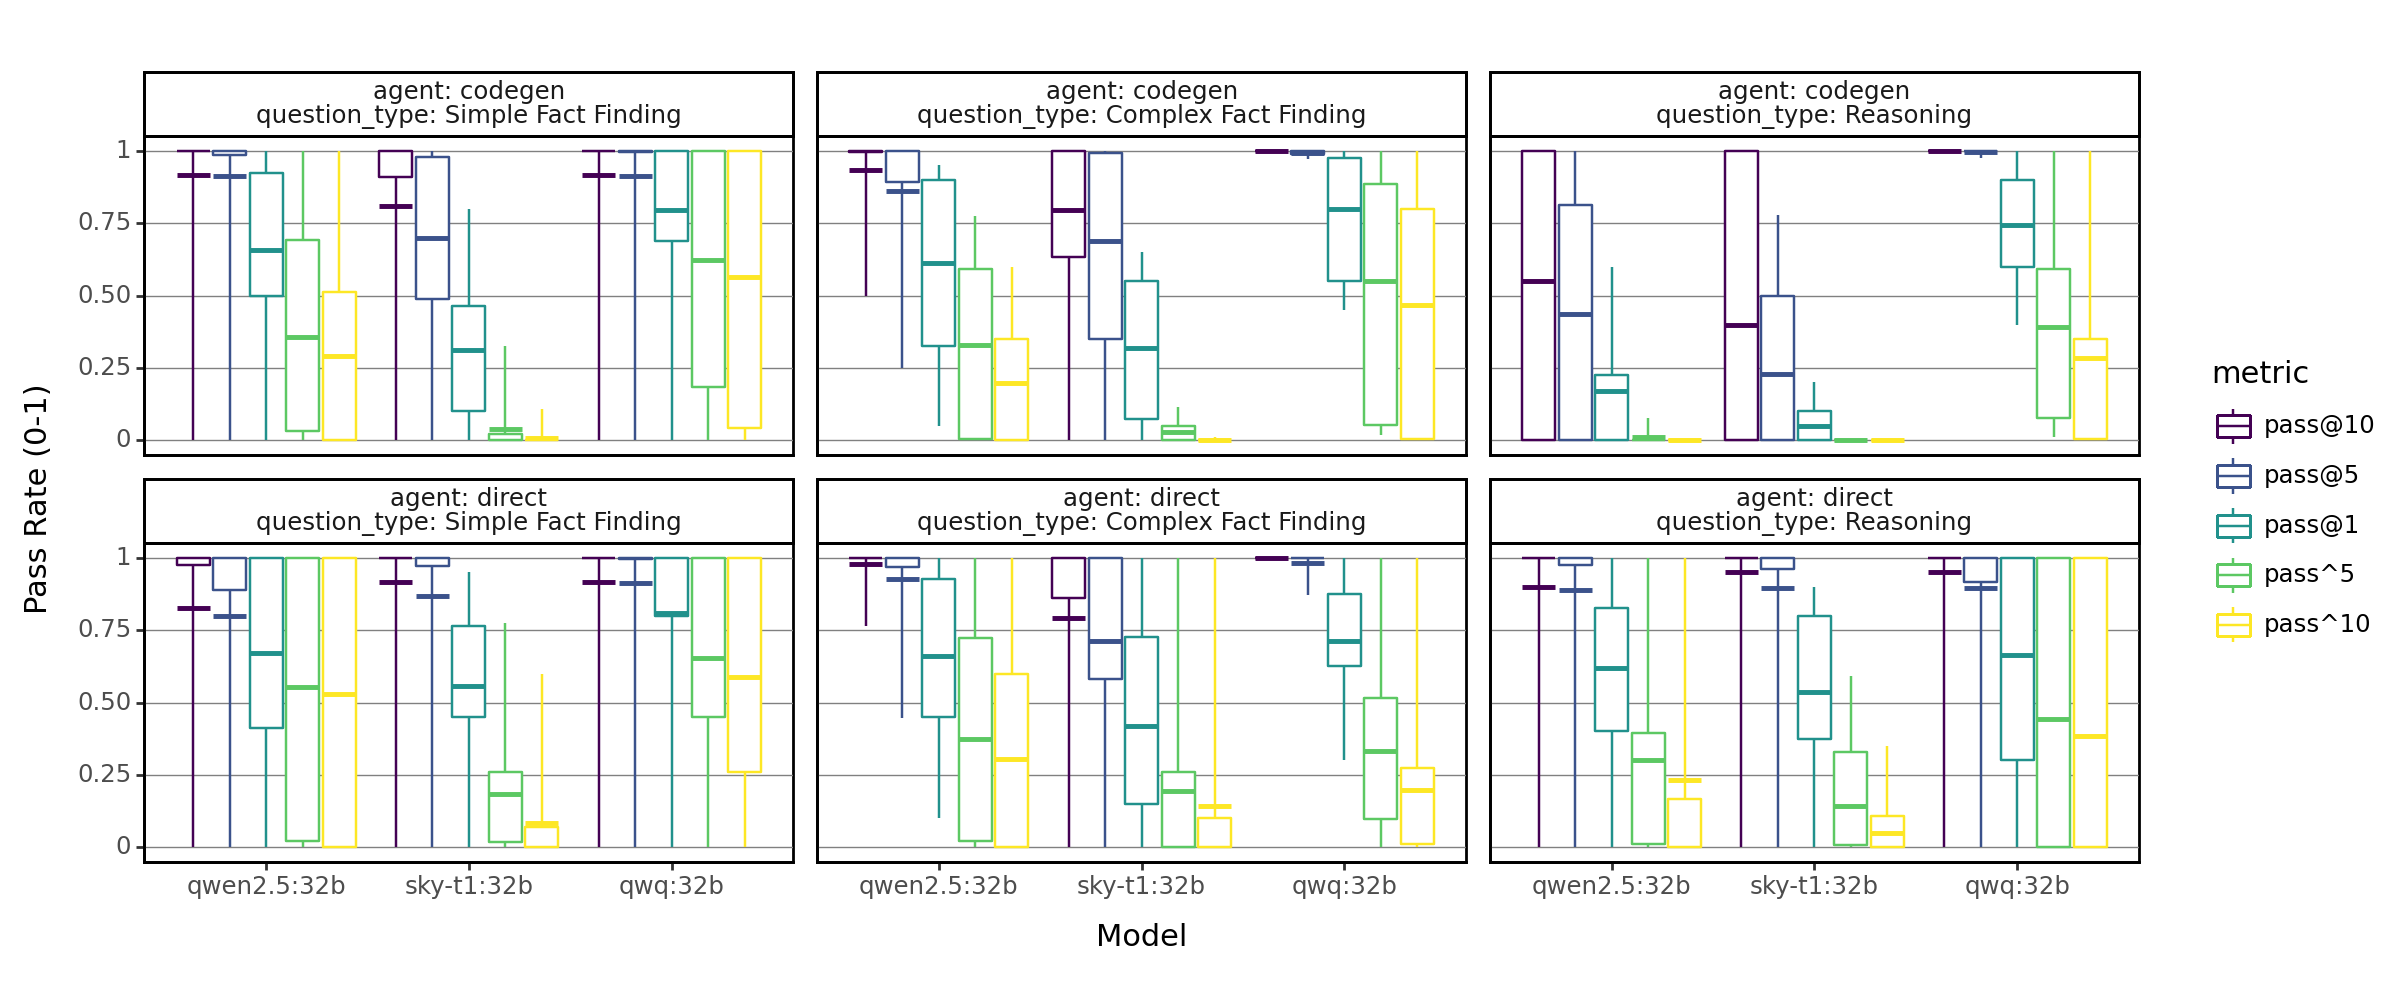

<Figure Size: (1200 x 500)>

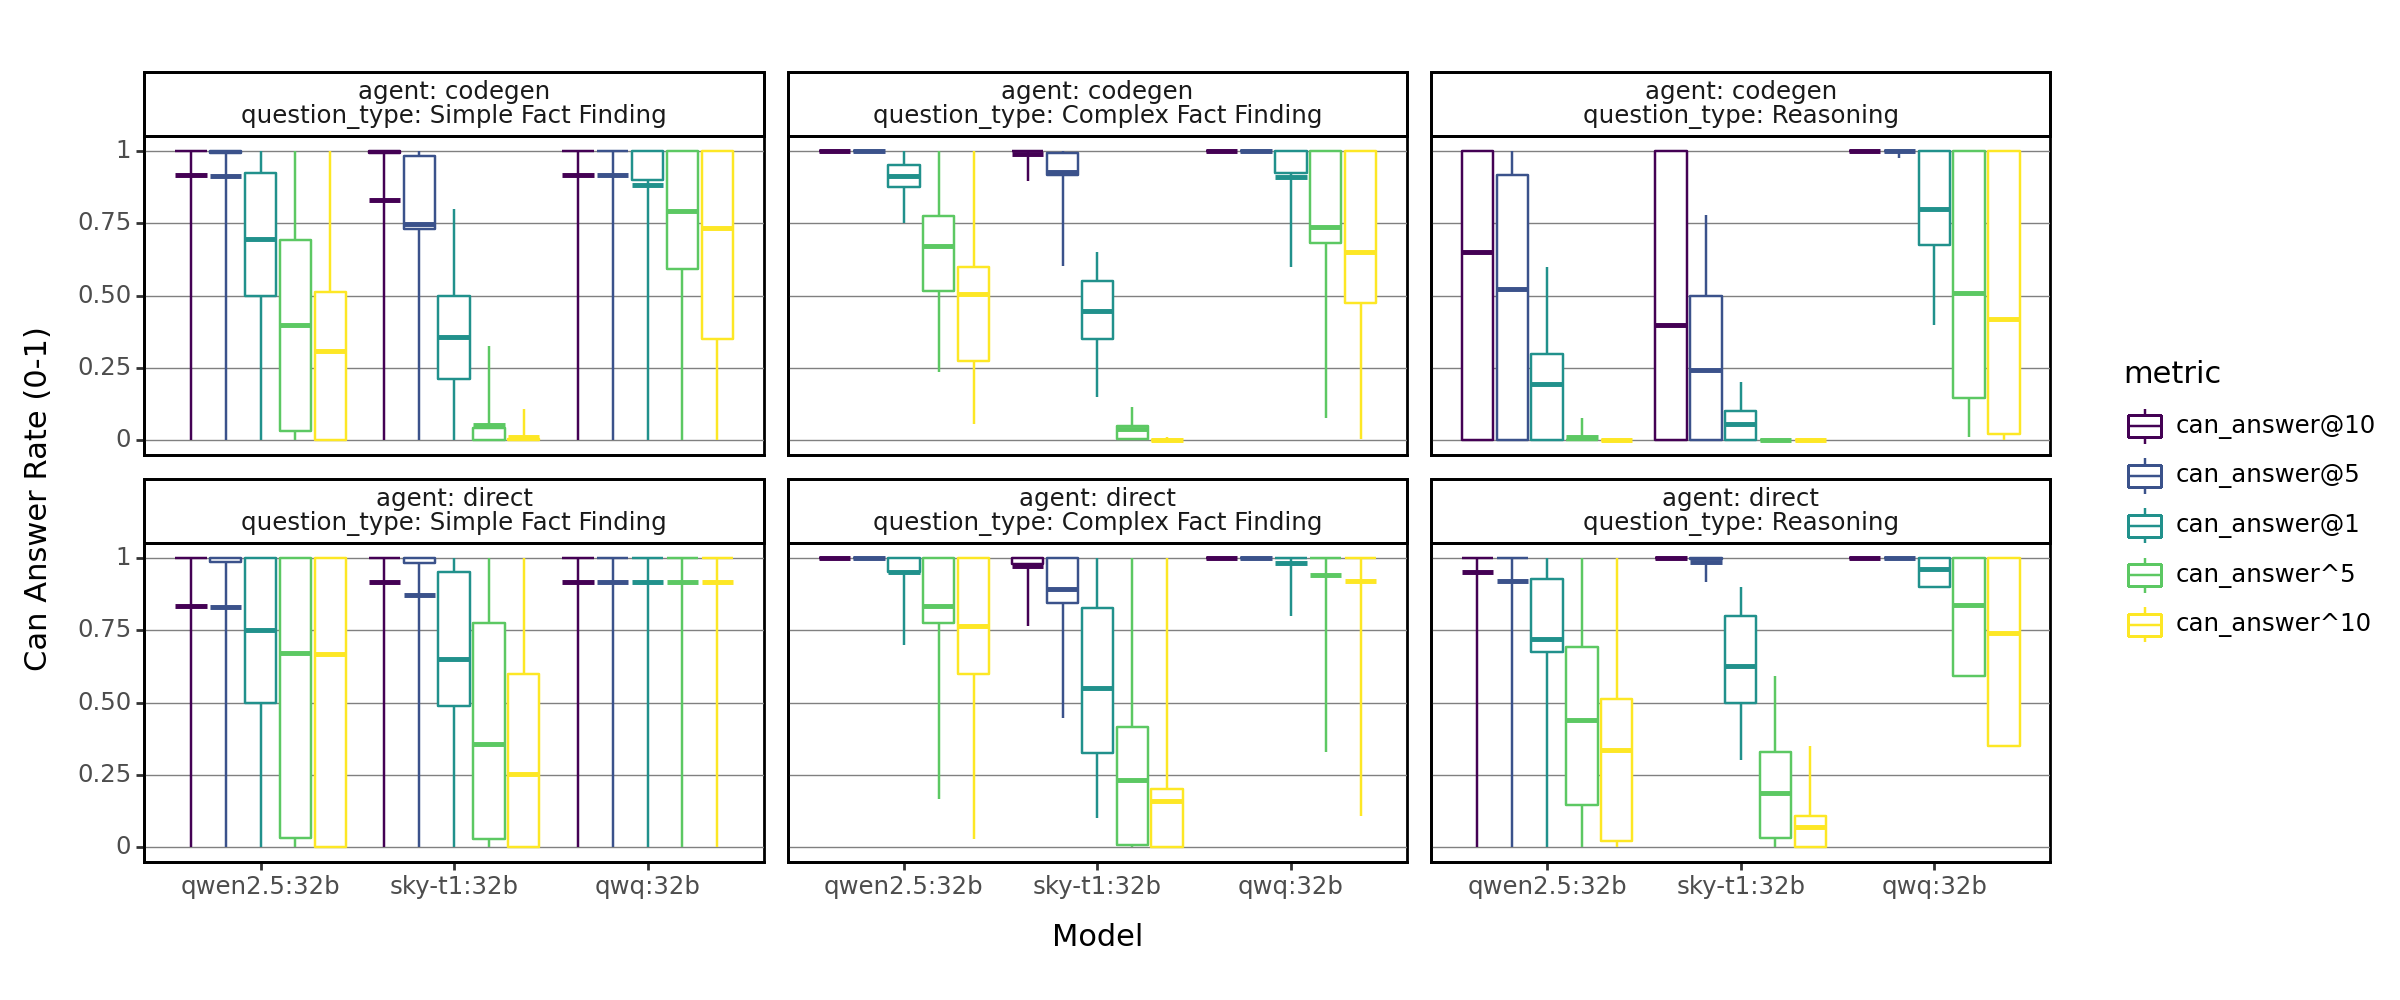

<Figure Size: (1200 x 500)>

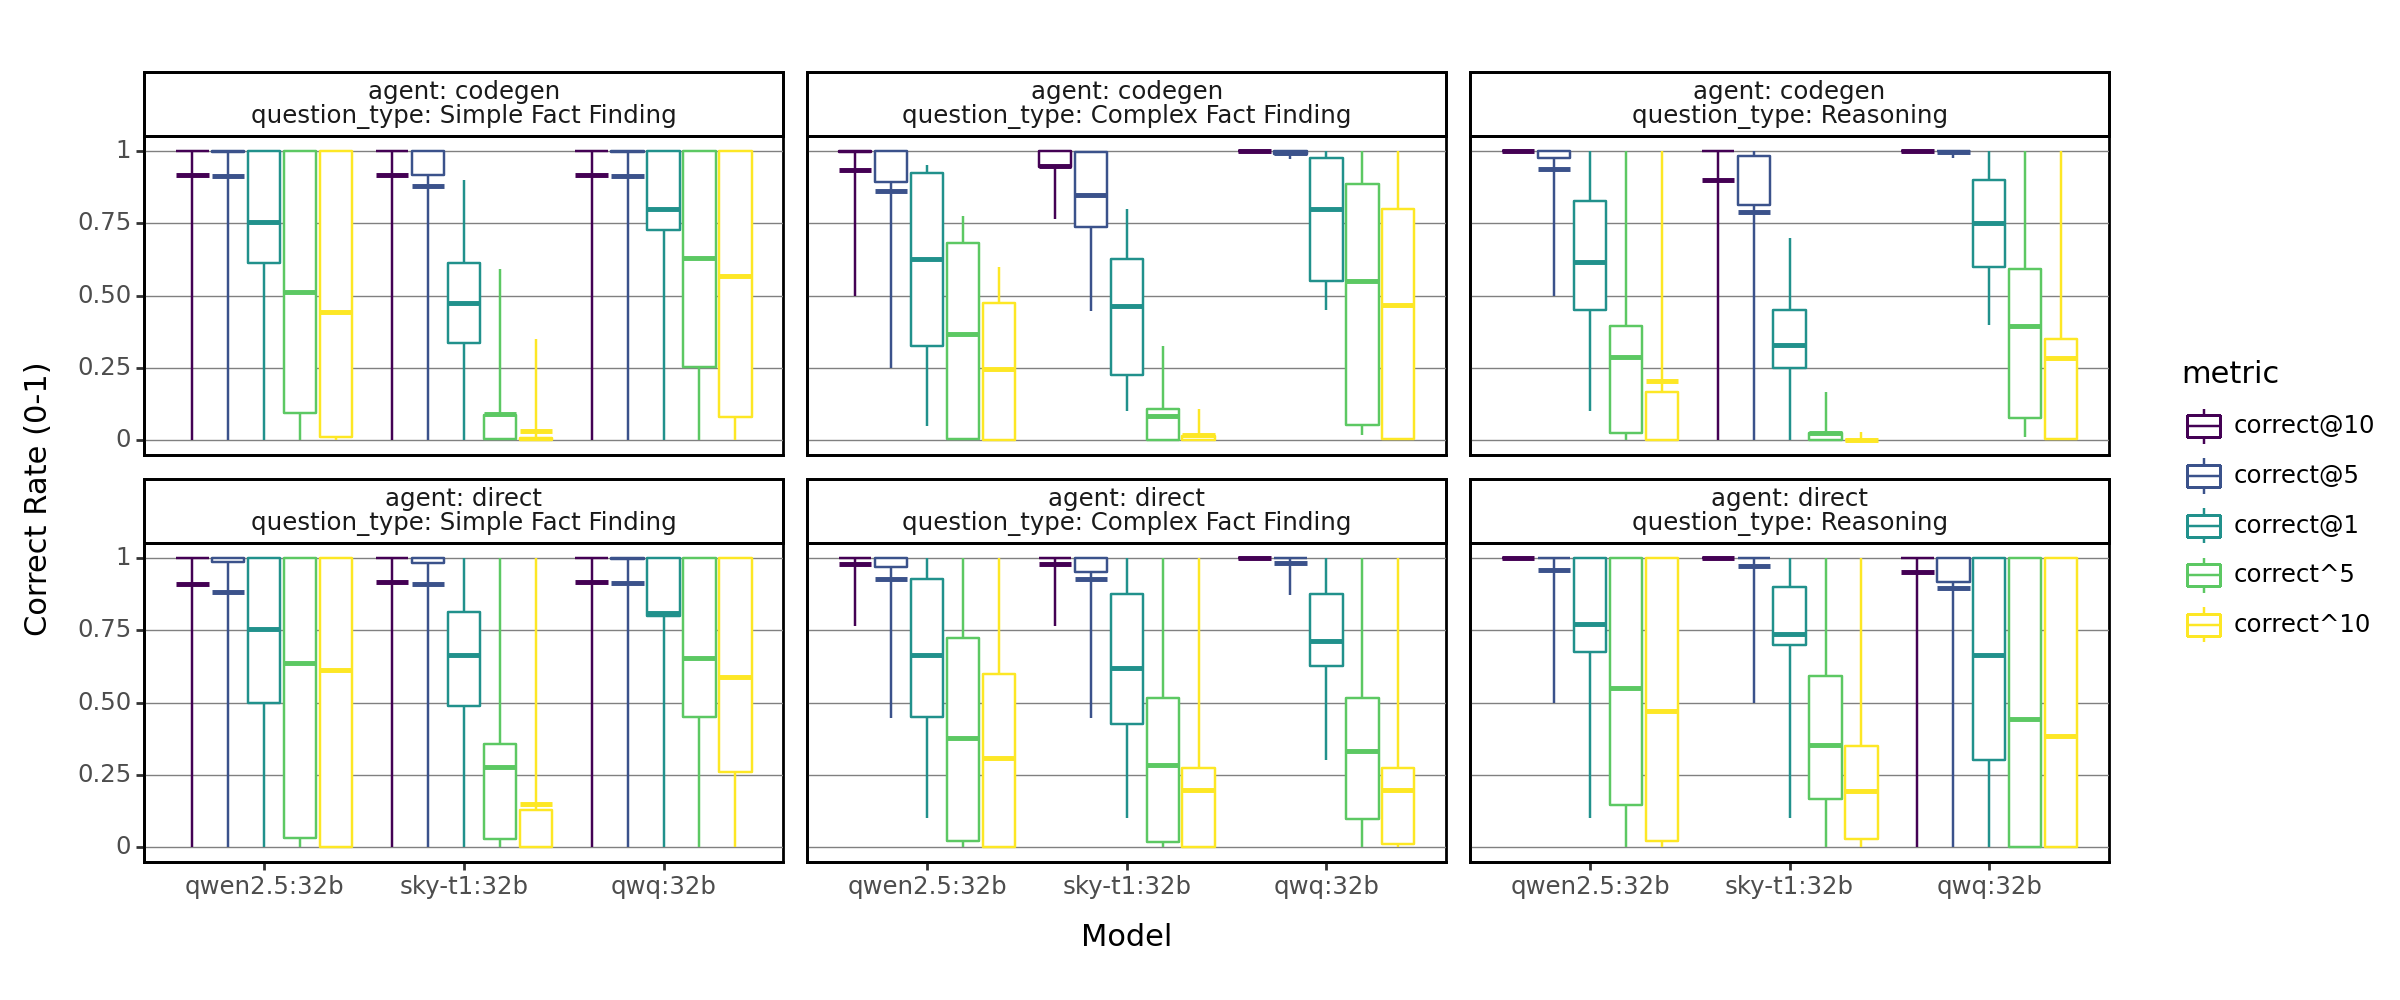

<Figure Size: (1200 x 500)>

In [7]:
_pass_metrics = [
    "pass@10",
    "pass@5",
    "pass@1",
    "pass^5",
    "pass^10",
]
_can_answer_metrics = [
    "can_answer@10",
    "can_answer@5",
    "can_answer@1",
    "can_answer^5",
    "can_answer^10",
]
_correct_metrics = [
    "correct@10",
    "correct@5",
    "correct@1",
    "correct^5",
    "correct^10",
]

_g0 = draw_metrics(raw_grouped,_pass_metrics, ylabel="Pass Rate (0-1)", height=5, facet=["agent", "question_type"])
_g1 = draw_metrics(raw_grouped, _can_answer_metrics, ylabel="Can Answer Rate (0-1)", height=5, facet=["agent", "question_type"])
_g2 = draw_metrics(raw_grouped, _correct_metrics, ylabel="Correct Rate (0-1)", height=5, facet=["agent", "question_type"])
display(_g0)
display(_g1)
display(_g2)
_g0.save(f"{OUTPUT_PATH}/reasoning_pass.png", bbox_inches="tight", dpi=300)
_g1.save(f"{OUTPUT_PATH}/reasoning_can_answer.png", bbox_inches="tight", dpi=300)
_g2.save(f"{OUTPUT_PATH}/reasoning_correct.png", bbox_inches="tight", dpi=300)
# _g.savefig(f"{OUTPUT_PATH}/reasoning_performance_breakdown.png")

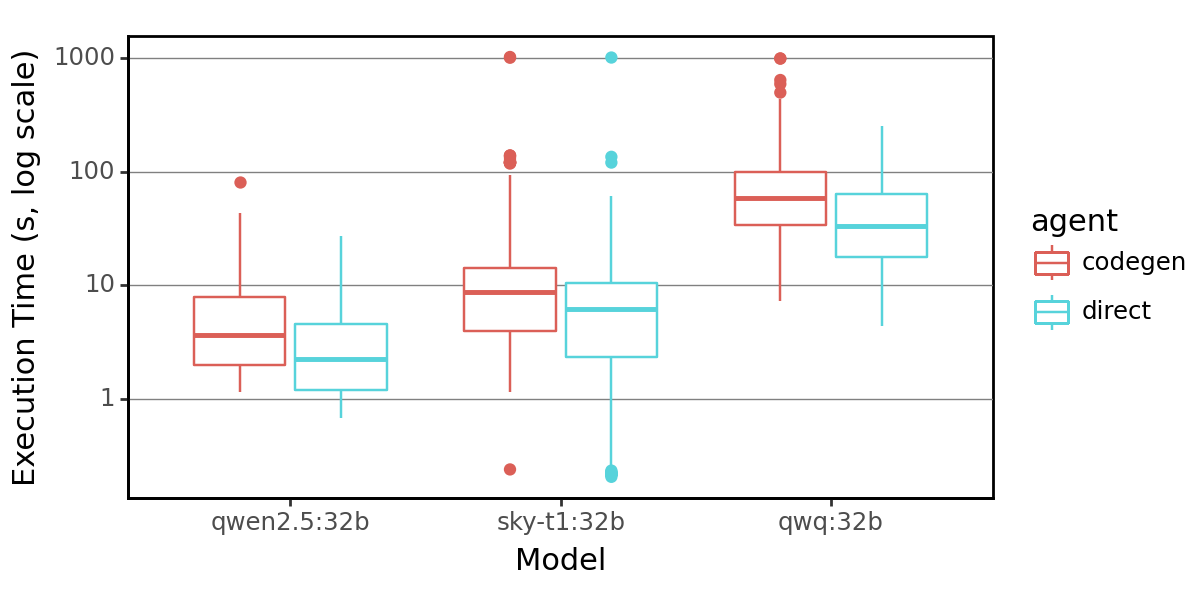

<Figure Size: (600 x 300)>

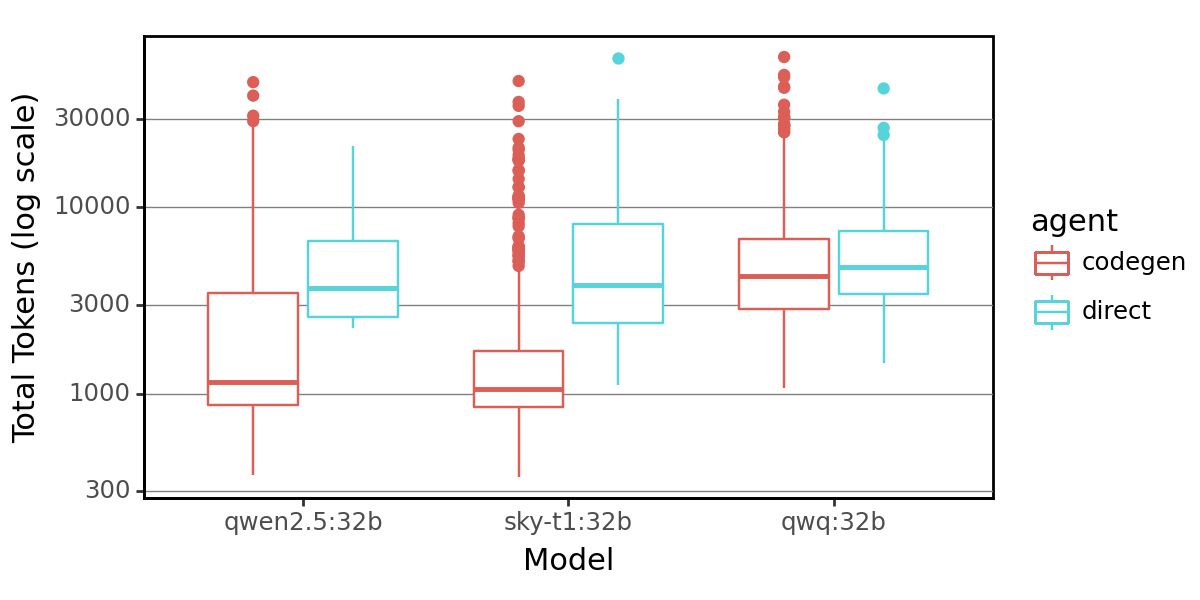

<Figure Size: (600 x 300)>

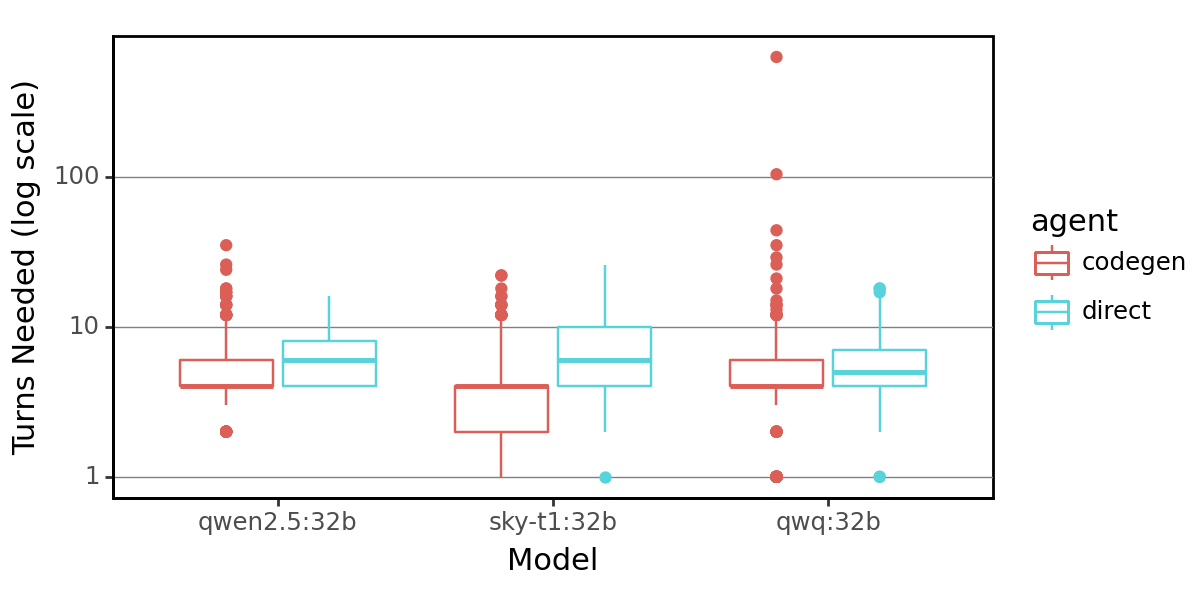

<Figure Size: (600 x 300)>

In [8]:
_g1 = (
    ggplot(df, aes(x="model", y="execution_time", color="agent"))
    # + geom_bar(stat="identity", position="dodge")
    + pn.geom_boxplot(position="dodge2")
    # + facet_wrap(["agent", "question_type"], labeller="label_both")
    + scale_y_log10()
    + labs(
        x="Model",
        y="Execution Time (s, log scale)",
        # title="Execution Time",
    )
    + my_theme(6, 3)
)
display(_g1)

_g2 = (
    ggplot(df, aes(x="model", y="total_tokens", color="agent"))
    # + geom_bar(stat="identity", position="dodge")
    + pn.geom_boxplot(position="dodge2")
    + scale_y_log10()
    # + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Total Tokens (log scale)",
        # title="Total Tokens",
    )
    + my_theme(6, 3)
)
display(_g2)

_g3 = (
    ggplot(df, aes(x="model", y="num_messages", color="agent"))
    # + geom_bar(stat="identity", position="dodge")
    + pn.geom_boxplot(position="dodge2")
    + scale_y_log10()
    # + facet_wrap(["agent", "question_type"], labeller="label_both")
    + labs(
        x="Model",
        y="Turns Needed (log scale)",
        # title="Total Tokens",
    )
    + my_theme(6, 3)
)
display(_g3)

_g1.draw().savefig(f"{OUTPUT_PATH}/reasoning_execution_time.png", bbox_inches="tight", dpi=300)
_g2.draw().savefig(f"{OUTPUT_PATH}/reasoning_total_tokens.png", bbox_inches="tight", dpi=300)
_g3.draw().savefig(f"{OUTPUT_PATH}/reasoning_num_messages.png", bbox_inches="tight", dpi=300)